# Bitcoin Time Series Prediction with LSTM

#### Import necessary library needed for the model training

In [316]:
from math import sqrt
from matplotlib import pyplot
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline
pd.options.display.expand_frame_repr = False

#### Read data set

In [ ]:
data1 = pd.read_csv(filepath_or_buffer="bitcoinprices.txt")
data2 = pd.read_csv(filepath_or_buffer="sentiment.txt")

#### Join on data frame

In [318]:
data = pd.merge(data1,data2, on='stamp', how='inner')
data.describe()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643 entries, 0 to 642
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   stamp      643 non-null    int64  
 1   price      643 non-null    float64
 2   sentiment  642 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 15.2 KB


In [319]:
data = data.sort_values(by='stamp')
data['stamp'] = pd.to_datetime(data['stamp'].apply(str),format='%Y%m%d')
data.head()

,stamp,price,sentiment
573,2016-02-11,379.2,0.306488
427,2016-02-12,389.0,0.260142
212,2016-02-13,397.7,0.304902
113,2016-02-14,406.8,0.308635
590,2016-02-15,400.9,0.321268


#### Plot line graph base on `Weighted Price`

In [320]:
# Заполняем NaN предыдущей ценой
columns = data.columns
for column in columns:
    data[column].replace(0, np.nan, inplace=True)
    data[column].fillna(method='ffill', inplace=True)

btc_trace = go.Scatter(x=data['stamp'], y=data['price'], name= 'Price')
py.iplot([btc_trace])

#### Function to convert series to supervised learning

In [321]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#### Use MinMaxScaler to normalize `Weighted Price` to range from 0 to 1

In [322]:
price = data['price'].values.reshape(-1,1)
sentiment = data['sentiment'].values.reshape(-1,1)

price = price.astype('float32')
sentiment = sentiment.astype('float32')

scaler1, scaler2 = MinMaxScaler(feature_range=(0, 1)),  MinMaxScaler(feature_range=(0, 1))

price = scaler1.fit_transform(price)
sentiment = scaler2.fit_transform(sentiment)

reframed = series_to_supervised(price, 1, 1)
reframed['sentiment'] = sentiment[:-1]
print(reframed.tail())
#values = np.column_stack((a_b, sentiment))
values = reframed.values

     var1(t-1)   var1(t)  sentiment
638   0.958527  0.889491   0.752559
639   0.889491  0.801623   0.752559
640   0.801623  0.824363   0.752559
641   0.824363  0.870632   0.752559
642   0.870632  0.869928   0.752559


#### Split 70% of data for training and 30% for testing

In [323]:
train_size = int(len(values) * 0.7)
train, test = values[0:train_size], values[train_size::]

#### Create function for creating dataset with look back

In [324]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(look_back, len(dataset)):
        dataX.append(dataset[i-look_back:i])
        dataY.append([dataset[i][0]])
    return np.array(dataX), np.array(dataY)


#### Generate dataset for trainX, trainY, testX, testY

In [325]:
lb = 2
trainX, trainY = create_dataset(train, lb)
testX, testY = create_dataset(test, lb)
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(448, 1, 3) (448, 1) (192, 1, 3) (192, 1)


#### Running the LSTM model with 300 epochs

In [326]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2]), activation='relu'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, verbose=0, shuffle=False, validation_data=(testX, testY))

#### Plot line graph to show amount loss according the epoch

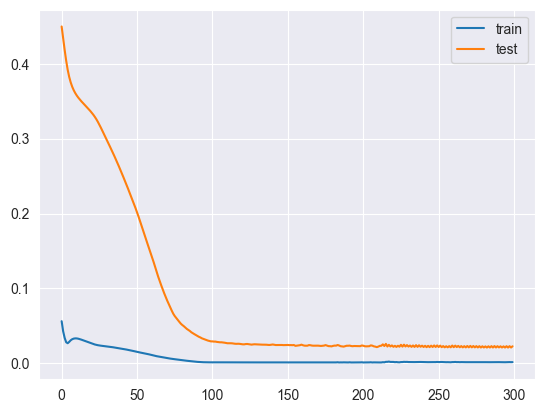

In [327]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

#### Make prediction using testX and plotting line graph against testY

6/6 [==============================] - 0s 2ms/step
192


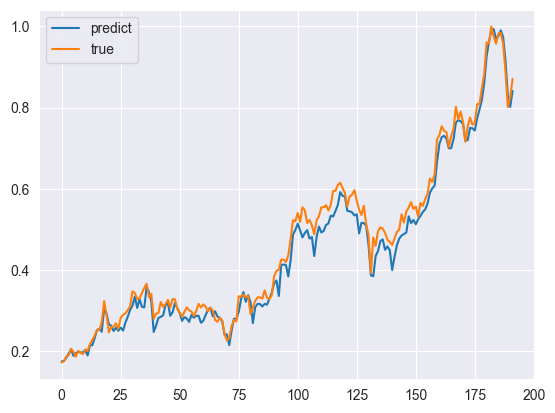

In [328]:
yhat = model.predict(testX)
print(len(yhat))
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

#### Scaler Inverse Y back to normal value

In [329]:
testY_inverse = scaler1.inverse_transform(testY)
yhat_inverse = scaler1.inverse_transform(yhat)

#### RMSE

In [330]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: {}'.format(rmse))

Test RMSE: 203.02111766698064


#### Convert X to dates

In [331]:
predictDates = data.tail(len(testX)).stamp

#### Plot line graph with Y as USD

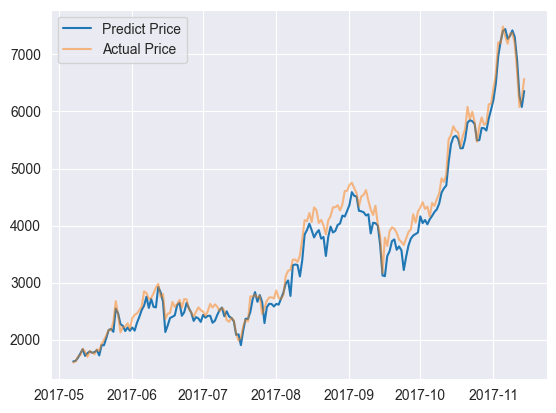

In [332]:
pyplot.plot(predictDates, yhat_inverse, label='Predict Price')
pyplot.plot(predictDates, testY_inverse, label='Actual Price', alpha=0.5)
pyplot.legend()
pyplot.show()

#### Reshape testY and yhat for plotly

In [333]:
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

#### Plot predicted and actual line graph with X=dates, Y=USD

In [334]:
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
py.iplot([predict_chart, actual_chart])

### Using additional features for model training

#### Find corrleration in features to `Weighted Price`

<Axes: >

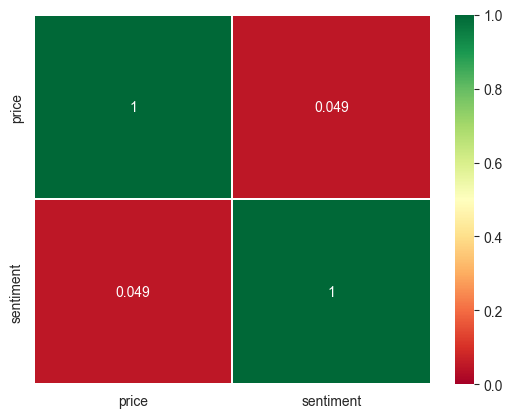

In [335]:
sns.heatmap(data[['price','sentiment']].corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)

Observation: `Volume` is corrlerated to `Weighted Price`.
`Open`, `High`, `Low`, `Close` are directly related to `Weighted Price`